<a href="https://colab.research.google.com/github/pedrofuentes79/RNNs/blob/master/sentAnalysis_DEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Idea for the project

The project is aimed to solve the following problem: given a review (or any piece of text), classify it as positive or negative. Since it was trained using amazon product reviews, it was tested on those same types of text: product reviews.  

This problem is solved using a <b>RNN</b> (Recursive Neural Network), which is a type of neural network that is able to take into account the previous information that it was given. In this particular problem, sentiment analysis, it is important to take into account the previous words in order to understand the context of the sentence. For example, the sentence "I love this product" is positive, but "I don't love this product" is negative.

# Imports and dataset

In [1]:
#!pip install fasttext

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking, GRU, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from gensim.models import KeyedVectors, Word2Vec
from nltk.tokenize import word_tokenize
import fasttext.util

In [3]:
# Global variables
SAMPLE_SIZE = 50000

tf.random.set_seed(42)
np.random.seed(42)

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 500k reviews
#df_downsampled = pd.read_csv('/content/drive/MyDrive/ColabProjects/amazonreviews_relevantcolumns.csv')

# 50k reviews
df_downsampled = pd.read_csv("/content/drive/MyDrive/ColabProjects/amazonreviews_downsampled.csv")

# Data visualization
I want to see the distribution of the scores of the reviews to see if my dataset is imbalanced.

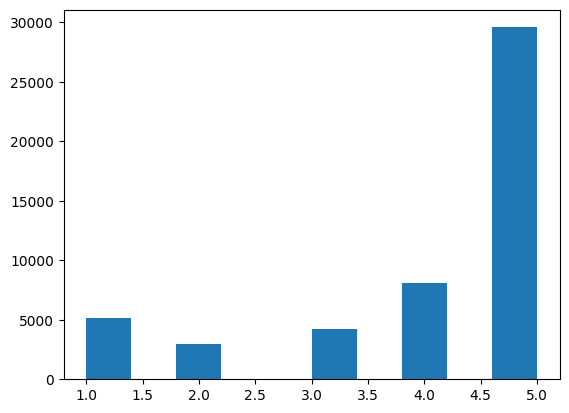

In [7]:
plt.hist(df_downsampled["Score"])
plt.show()

The imbalance after downsampling (done previously) is still there, but a little bit better. However, we will settle for this, since production data would likely have a similar distribution.

### Stopwords and Lemmatizing

Removing the stopwords means taking away the most common words in the english language, those that are not very significant when trying to analyze the sentiment in a sentence.

Lemmatizing means reducing each word to its "lemma", or the root of the word. For example, the lemma of "running" is "run". This is useful because it reduces the number of words that the model has to learn, and it also helps to group together words that have the same meaning.

In [8]:
# Remove stopwords
stop = nltk.corpus.stopwords.words('english')
lemmatized_text = df_downsampled['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatized_text = lemmatized_text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

### Scores (target variable)


In [9]:
# Map scores to 0 and 1
# I have Decided to map 1,2,3 to 0 and 4,5 to 1
# So, now we have a binary classification problem; 0 for negative sentiment and 1 for positive
y = df_downsampled["Score"].map({1:0, 2:0, 3:0, 4:1, 5:1})

y = y.values.astype("float32")

### Tokenize the text

Tokenizing the text is basically splitting the text into words. Using the NLTK library to tokenize the text.

In [10]:
tokenized_text = [word_tokenize(i) for i in lemmatized_text]

### Word embeddings


Here, we load a previously trained model on this particular dataset. However, there are many alternatives for different models, as well as pretrained models that can be downloaded from the internet. For example, the [Stanford NLP group](https://nlp.stanford.edu/projects/glove/) has a set of pretrained models that can be used for sentiment analysis.

In [11]:
# This model was previously trained with this same dataset.
# The model was saved in a binary file with model.save()



#model = Word2Vec(tokenized_text, vector_size=150, window=5, min_count=1, workers=4)
model.save("/content/drive/MyDrive/ColabProjects/model-50k-reviews.bin")

# Model trained on this dataset
#model = KeyedVectors.load("/content/drive/MyDrive/ColabProjects/model-500k-reviews.bin")

# Pretrained model
#model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/ColabProjects/GoogleNews-vectors-negative300.bin", binary=True)

#model = Word2Vec(tokenized_text, vector_size=128, window=5, min_count=1, workers=4)
#model.save("/content/drive/MyDrive/ColabProjects/model-500k-reviews.bin")

In [12]:
# FastText model


#model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/ColabProjects/wiki-news-300d-1M-subword.vec")


In [13]:
# Assigns each word in every sentence of every sequence a vector of the model.
# Depending if the model was loaded using load_word2vec_format, one would have to replace these:
# model.key_to_index <=> model.wv
# model.get_vector(token) <=> model.wv[token]

def create_sequences(tokenized_text, model):
    sequences = []
    for seq in tokenized_text:
        seq_vectors = []
        for token in seq:
            if token in model.wv:
                seq_vectors.append(model.wv[token])
            else:
                seq_vectors.append(np.zeros((model.vector_size,)))
        sequences.append(seq_vectors)

    return sequences


sequences = create_sequences(tokenized_text, model)

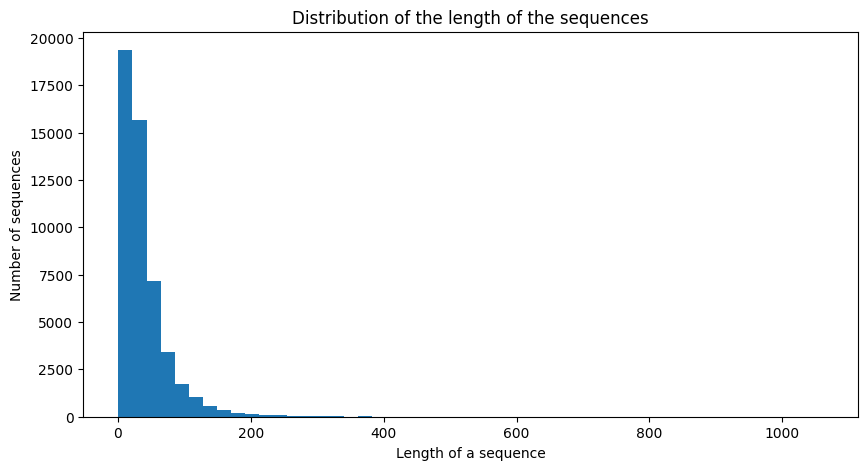

In [14]:
# Distribution of the length of the sequences
plt.figure(figsize=(10, 5))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('Length of a sequence')
plt.ylabel('Number of sequences')
plt.title('Distribution of the length of the sequences')
plt.show()


### Padding the sequences


This step is crucial, due to the fact that LSTMs cannot handle inhomogenous data, meaning that each sequence must be of the same length. The scikit learn pad_sequences function allows us to do this. We will pad the sequences with zeros, meaning that the sequences will be added the necessary zeros at the end. We will also need to define the maximum length of the sequences, which we will set to 80 in this case, by looking at the previous graph. This means that sequences with length less than 80 will be padded with zeros, and sequences with length greater than 80 will be truncated to 80.

In [15]:
sequences_padded = pad_sequences(sequences, maxlen=80, padding='post', truncating='post', dtype='float32')

In [16]:
# How many sequences have more than 80 tokens?
print("Number of sequences with more than 80 tokens: ", len([x for x in sequences if len(x) > 90]))

Number of sequences with more than 80 tokens:  3865


# Data split

In [17]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [18]:
# Print shapes to check
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)



X_train shape:  (40000, 80, 128)
X_val shape:  (5000, 80, 128)
X_test shape:  (5000, 80, 128)
y_train shape:  (40000,)
y_val shape:  (5000,)
y_test shape:  (5000,)


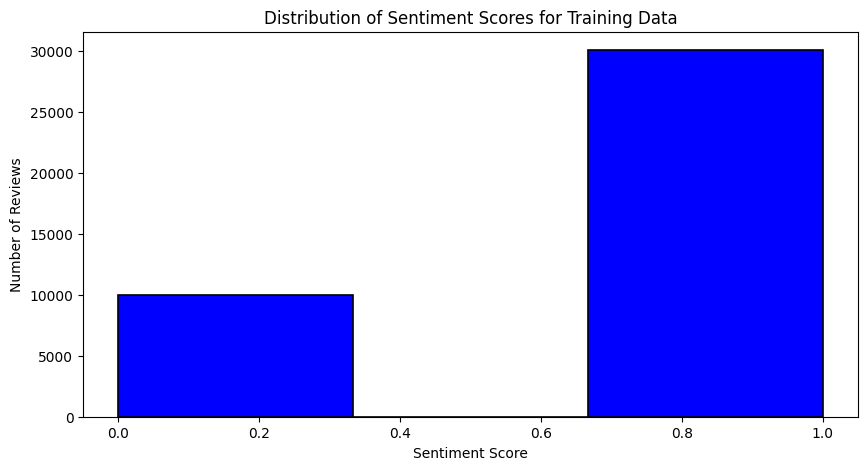

In [19]:
# Analyze distribution of sentiment scores training dataset
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=3, color='blue', edgecolor='black', linewidth=1.2)
plt.title('Distribution of Sentiment Scores for Training Data')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
plt.show()

In [20]:
# Amount of 0s and amount of 1s in the y_train array
print(np.unique(y_train, return_counts=True))


(array([0., 1.], dtype=float32), array([ 9942, 30058]))


So, there are 1977 negative reviews and 6023 positive reviews in the training set.

# Model

Here, I am using LSTM layers, but I also could have used GRU layers (Gated Recurrent Units).   
For regularization, I am using dropout layers with 0.5 as the dropout rate.  
Since this is a binary classification problem, I am using a sigmoid activation function in the output layer, as well as a binary_crossentropy loss function.
The learning rate in the Adam optimizer is set to 0.0005 due to overfitting issues when using the default value of 0.001.

In [21]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
#class_weights = dict(enumerate(class_weights))
class_weights = tf.constant(class_weights)

class_weights2 = {0: 1.5, 1: 0.8}

no_weights = {0: 1, 1: 1}

print(class_weights)
print(class_weights2)


def weighted_binary_crossentropy(y_true, y_pred, class_weights):
    # Calculate the binary cross-entropy loss
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

    # Apply class weights to the loss
    weighted_loss = loss * class_weights

    return weighted_loss


tf.Tensor([2.01166767 0.66538026], shape=(2,), dtype=float64)
{0: 1.5, 1: 0.8}


In [22]:
rnn = Sequential()
#masking layer to mask the padded zeros
rnn.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
rnn.add(LSTM(50, return_sequences=False, dropout=0.4, kernel_regularizer=l2(0.01)))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss=weighted_binary_crossentropy,
            optimizer=Adam(learning_rate=0.0005),
            metrics=['Precision', 'Recall', 'accuracy'])


In [23]:
H = rnn.fit(X_train, y_train,
            epochs=12,
            validation_data=(X_val, y_val))
            #callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True))

Epoch 1/12
1250/1250 [==============================] - 110s 81ms/step - loss: 0.6959 - precision: 0.8467 - recall: 0.9223 - accuracy: 0.8161 - val_loss: 0.3908 - val_precision: 0.8764 - val_recall: 0.9395 - val_accuracy: 0.8532
Epoch 2/12
1250/1250 [==============================] - 98s 78ms/step - loss: 0.4015 - precision: 0.8705 - recall: 0.9261 - accuracy: 0.8410 - val_loss: 0.3513 - val_precision: 0.8902 - val_recall: 0.9332 - val_accuracy: 0.8616
Epoch 3/12
1250/1250 [==============================] - 97s 78ms/step - loss: 0.3797 - precision: 0.8722 - recall: 0.9301 - accuracy: 0.8451 - val_loss: 0.3373 - val_precision: 0.8829 - val_recall: 0.9511 - val_accuracy: 0.8668
Epoch 4/12
1250/1250 [==============================] - 97s 78ms/step - loss: 0.3691 - precision: 0.8740 - recall: 0.9320 - accuracy: 0.8480 - val_loss: 0.3327 - val_precision: 0.8882 - val_recall: 0.9443 - val_accuracy: 0.8672
Epoch 5/12
1250/1250 [==============================] - 97s 78ms/step - loss: 0.3639 - 

## Predictions

In [24]:
predictions = rnn.predict(X_test)

# Round predictions
y_pred = np.zeros(len(predictions))
for i in range(len(predictions)):
    if predictions[i] > 0.65:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# Print the precision and recall, among other metrics
print(classification_report(y_test, y_pred, digits=3))

157/157 [==============================] - 4s 18ms/step
              precision    recall  f1-score   support

         0.0      0.694     0.763     0.727      1214
         1.0      0.921     0.892     0.907      3786

    accuracy                          0.861      5000
   macro avg      0.808     0.828     0.817      5000
weighted avg      0.866     0.861     0.863      5000



In [25]:
print(predictions)

[[0.9914102 ]
 [0.9230518 ]
 [0.97897583]
 ...
 [0.9925742 ]
 [0.80772424]
 [0.986159  ]]


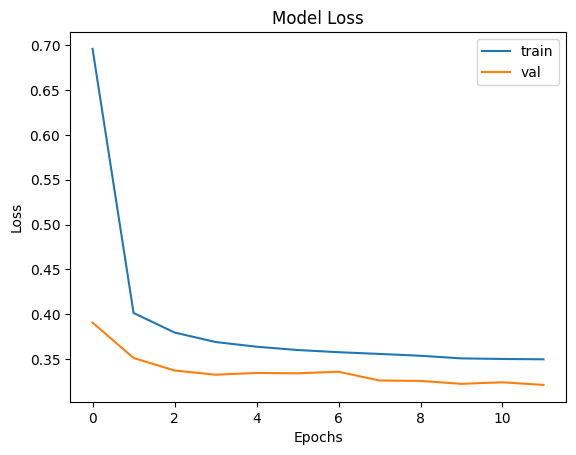

In [26]:
# plot the loss
plt.plot(H.history['loss'], label='train')
plt.plot(H.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



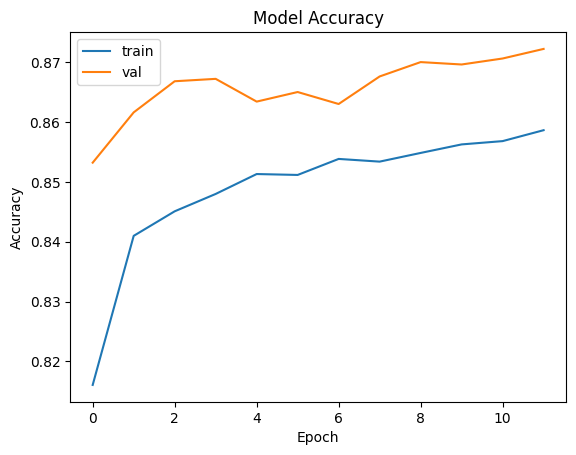

In [27]:
# Plot accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

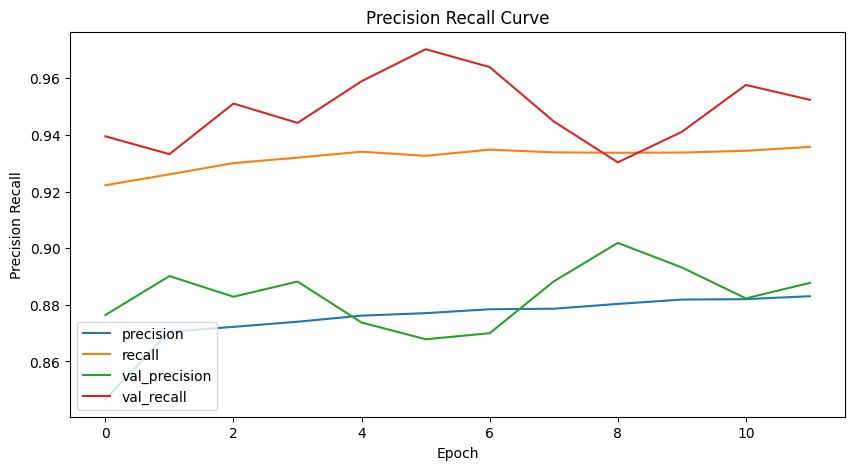

In [28]:
# Plot precision recall curve
plt.figure(figsize=(10, 5))
plt.plot(H.history['precision'], label='precision')
plt.plot(H.history['recall'], label='recall')
plt.plot(H.history['val_precision'], label='val_precision')
plt.plot(H.history['val_recall'], label='val_recall')
plt.title('Precision Recall Curve')
plt.xlabel('Epoch')
plt.ylabel('Precision Recall')
plt.legend(loc='lower left')
plt.show()